In [5]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.append("../code/")
from path_handler import PathHandler
paths=PathHandler()
import perform_bayes_fit as PBF
import one_gauss_bayes as OGB

open the data

In [6]:

def grab_raw_data_and_fit(survey_name, row_index, model_name='one_gauss'):
    """
    Grab the raw data and the fit from the bayes fit file.

    returns :
        fit_array: params x steps in chain 
        spectrum: the raw spectrum
        wavenumber: the wavenumber of the spectrum
        sclk: the spacecraft clock time of the observation
    """

    valid_models=['one_gauss','two_gauss']
    assert model_name in valid_models, f"model_name must be one of {valid_models}"
    path_to_fit=paths.bayes_fits_fname(survey_name, row_index,model_name=model_name)

    with h5py.File(path_to_fit,'r') as fp:
        fit_array=fp['chain'][:]
        spectrum=fp['chain'].attrs['spectrum'][:]
        wavenumber=fp['chain'].attrs['wavenumber'][:]
        sclk=fp['chain'].attrs['sclk']
        return fit_array, spectrum, wavenumber, sclk

        


In [7]:
def add_spectrum(fig,axis,wavenumber,spectrum,properties = {"facecolor":"white","label":"Spectrum","s":10,"marker":"o","edgecolors":"black"}):
    axis.scatter(wavenumber,spectrum,**properties)
    return fig, axis

def add_plot_fits_one_gauss(fig,axis,fit_array, wavenumber,properties={"alpha":0.01,"color":"black","zorder":0}):
    for i in range(fit_array.shape[1]):
        m=fit_array[0,i]
        b=fit_array[1,i]
        A=fit_array[2,i]
        k=fit_array[3,i]
        sigma=fit_array[4,i]
        spectrum=OGB.model_single_gauss_spec(wavenumber, b, m, A, k, sigma)
        continuum=PBF.continuum(wavenumber, b, m)
        axis.plot(wavenumber, spectrum, **properties)
        axis.plot(wavenumber, continuum, **properties)
        
    return fig, axis 

In [24]:
survey_name='EQ2'
row_index=10

In [25]:
fit_array, spectrum, wavenumber, sclk=grab_raw_data_and_fit(survey_name, row_index, model_name='one_gauss')

In [26]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',  # or 'serif', 'monospace', etc.
    'font.sans-serif': ['Bitstream Vera Serif']  # Replace with your desired font
})
AXIS = {
    "xlim": [wavenumber.min(),wavenumber.max()],
    "xlabel": "Wavenumber [cm$^{-1}$]",
    "ylabel": "Radiance",
}

In [27]:
figname = "one_gauss_fit_{:s}_{:s}.png".format(survey_name, str(row_index))
figname

'one_gauss_fit_EQ2_10.png'

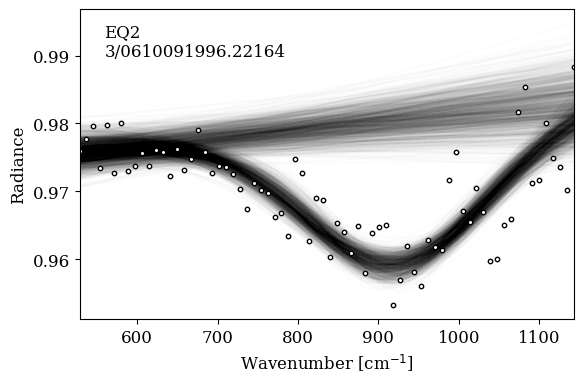

In [28]:
fig,axis=plt.subplots(1,1,figsize=(6,4))
fig,axis=add_spectrum(fig,axis,wavenumber,spectrum)
fig,axis=add_plot_fits_one_gauss(fig,axis,fit_array,wavenumber)
axis.set(**AXIS)    
axis.text(0.05,0.85,f"{survey_name}\n{sclk}",transform=axis.transAxes)
fig.tight_layout()
fig.savefig(figname)


# Fit params


In [29]:
import corner

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2406958/3493633985.py:1: SyntaxWarning: invalid escape sequence '\s'
  names = ['Slope', 'Intercept', 'Band Amplitude', 'Band Position', 'Band $\sigma$']


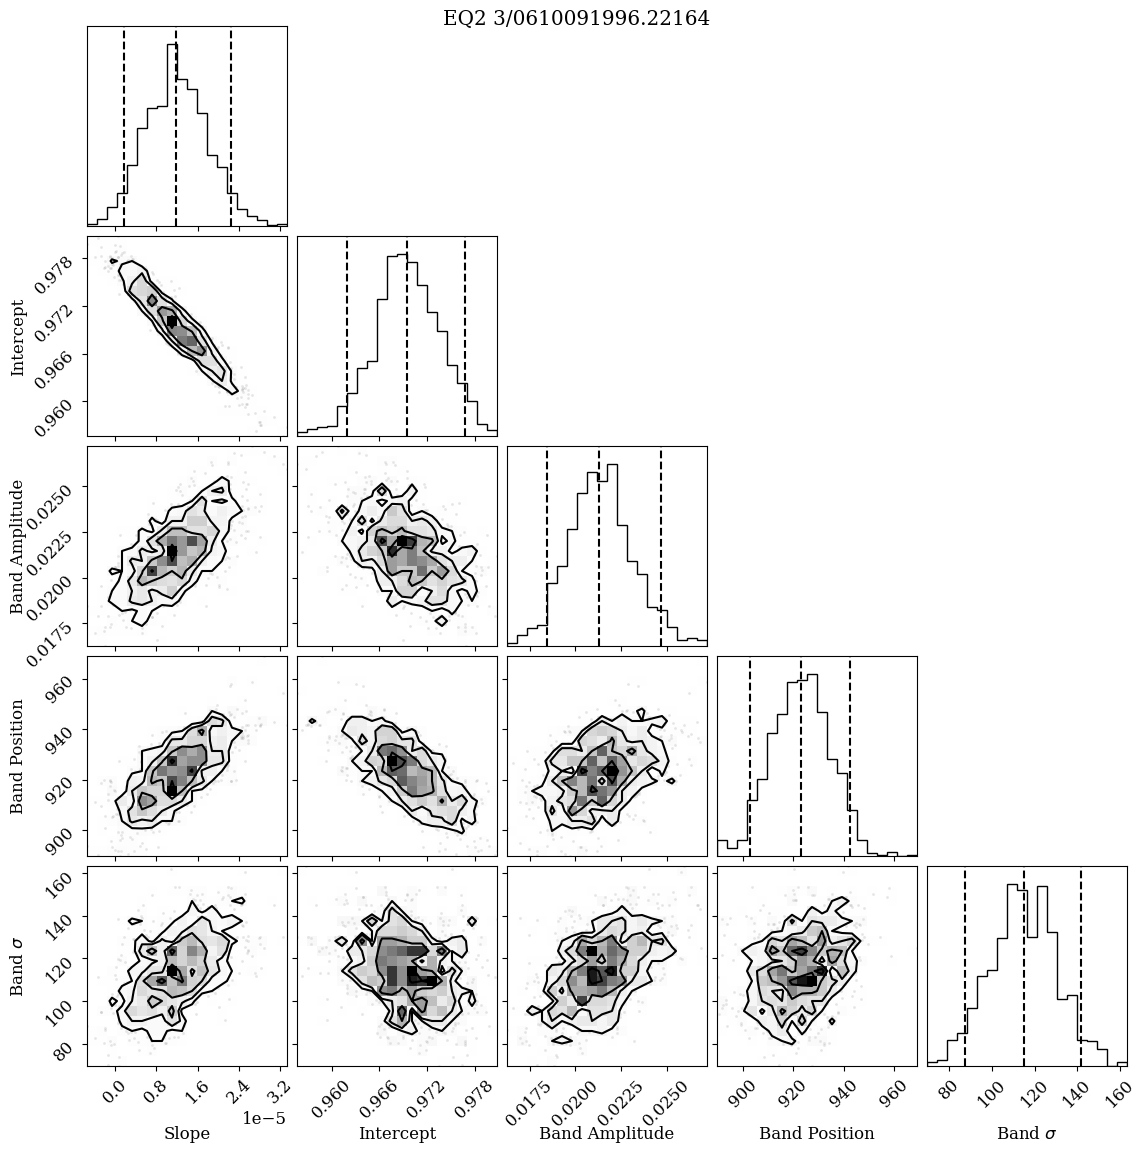

In [30]:
names = ['Slope', 'Intercept', 'Band Amplitude', 'Band Position', 'Band $\sigma$']
fig = corner.corner(fit_array.T, labels=names,quantiles=[1-0.96, 0.5, 0.96],show_titles=False)
fig.suptitle(f"{survey_name} {sclk}")
fig.savefig(f"corner_{survey_name}_{row_index}.png")